# MobileNet V1


In [1]:
# Setup
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from pathlib import Path 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision import transforms
import torchmetrics
from torchsummary import summary

# imported from separate python files
from mobilenet_v1 import MobileNet

In [2]:
# Config
num_class = 10
batch_size = 128
seed = 43
num_epoch = 20

# Data


In [3]:
# Define transformation on data
# -> Convert image to tensor
# -> Normalizing data with the specified values of mean and standard deviation 
transform = transforms.Compose(
    [   transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        

    ]
)

# Downloading the data (CIFAR10) from torchvision datasets
data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split the data into train and validation set
train_data, val_data = random_split(data, [0.9, 0.1])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Creating Dataloaders 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Class in CIFAR10 dataset
classes  = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

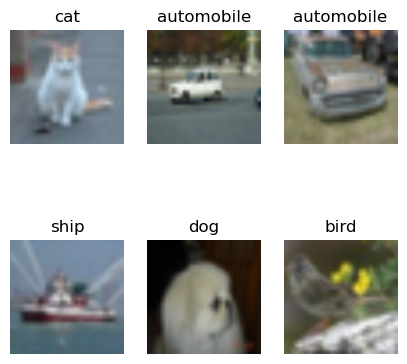

In [5]:
# Visualize an image
def imshow(img, label):
    # Unnormalize the image
    img = img * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1) + torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1) 
    npimg = img.numpy()
    

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')
    


# batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
plt.figure(figsize=(5, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], labels[i])

In [6]:
# GPU Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.manual_seed(seed)

cuda:0


In [7]:
# Training and testing functions

# Training function
def training_step(model, data_loader, optimizer, criterion, train_acc):
    model.train()
    running_loss = 0.0
    train_acc.reset()

    for  data in tqdm(data_loader):
        # get inputs
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients 
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()

        # metric
        running_loss = running_loss + loss.item()
        train_acc.update(outputs, labels)

    train_loss = running_loss / len(data_loader)
    train_accuracy = train_acc.compute().item()
    return train_loss, train_accuracy


# Validation function
def val_step(model, data_loader, criterion, val_acc):
    model.eval()
    val_loss = 0.0
    val_acc.reset()

    with torch.no_grad():
        for data in tqdm(data_loader):
            # get inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # metric
            val_loss = val_loss + loss.item()
            val_acc.update(outputs, labels)

    val_loss = val_loss / len(data_loader)
    val_accuracy = val_acc.compute().item()
    return val_loss, val_accuracy

def test_step(model, data_loader):
    model.eval()
    eval_loss = 0.0
    test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    test_acc.reset()

    all_label = []
    all_pred = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            # get inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, labels)

            # Convert logits to class predictions (using argmax)
            _, predicted = torch.max(outputs, 1)
            
            all_label.extend(labels.to('cpu').numpy())
            all_pred.extend(predicted.to('cpu').numpy())

            # metric
            eval_loss = eval_loss + loss.item()
            test_acc.update(outputs, labels)

    eval_loss = eval_loss / len(data_loader)
    test_accuracy = test_acc.compute().item()

    print(f'Test Accuracy: {test_accuracy:.2f}')
    print()

    # Classification Report
    print('Classification Report: ')
    print(classification_report(all_label, all_pred))

    

# Model Training 
def model_training(model, train_dataloader, val_dataloader, num_epoch, save_path, optimizer):

    # Setting up loss and optimizer
    criterion = nn.CrossEntropyLoss()

    # define metrics
    train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    best_val_accuracy = 0.0


    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        train_loss, train_accuracy = training_step(model, train_dataloader, optimizer, criterion, train_acc)
        val_loss, val_accuracy = val_step(model, val_dataloader, criterion, val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

        #  storing metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Save model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with Validation Accuracy: {best_val_accuracy:.2f}")

    
    # ploting train vs val loss and accuracy curve
    plt.figure(figsize=(12, 5))

    # ploting loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epoch + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epoch + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
model_mobilenet = MobileNet(num_class)
model_mobilenet.to(device)
summary(model_mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]             320
       BatchNorm2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 64, 112, 112]           2,112
       BatchNorm2d-6         [-1, 64, 112, 112]             128
            Conv2d-7           [-1, 64, 56, 56]             640
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 128, 56, 56]           8,320
      BatchNorm2d-10          [-1, 128, 56, 56]             256
           Conv2d-11          [-1, 128, 56, 56]           1,280
      BatchNorm2d-12          [-1, 128, 56, 56]             256
           Conv2d-13          [-1, 128, 56, 56]          16,512
      BatchNorm2d-14          [-1, 128,

## Model Training

100%|██████████| 40/40 [00:05<00:00,  6.78it/s]


Epoch 1, Train Loss: 2.1560, Train Accuracy: 0.19, Validation Loss: 1.9929, Validation Accuracy: 0.26
Model saved with Validation Accuracy: 0.26


100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


Epoch 2, Train Loss: 1.7951, Train Accuracy: 0.31, Validation Loss: 1.7112, Validation Accuracy: 0.34
Model saved with Validation Accuracy: 0.34


100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Epoch 3, Train Loss: 1.6583, Train Accuracy: 0.36, Validation Loss: 1.6300, Validation Accuracy: 0.37
Model saved with Validation Accuracy: 0.37


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Epoch 4, Train Loss: 1.5692, Train Accuracy: 0.41, Validation Loss: 1.5343, Validation Accuracy: 0.42
Model saved with Validation Accuracy: 0.42


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 5, Train Loss: 1.4616, Train Accuracy: 0.46, Validation Loss: 1.4546, Validation Accuracy: 0.47
Model saved with Validation Accuracy: 0.47


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 6, Train Loss: 1.3577, Train Accuracy: 0.50, Validation Loss: 1.3315, Validation Accuracy: 0.51
Model saved with Validation Accuracy: 0.51


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Epoch 7, Train Loss: 1.2506, Train Accuracy: 0.55, Validation Loss: 1.2460, Validation Accuracy: 0.54
Model saved with Validation Accuracy: 0.54


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Epoch 8, Train Loss: 1.1576, Train Accuracy: 0.58, Validation Loss: 1.1646, Validation Accuracy: 0.57
Model saved with Validation Accuracy: 0.57


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Epoch 9, Train Loss: 1.0921, Train Accuracy: 0.61, Validation Loss: 1.1667, Validation Accuracy: 0.58
Model saved with Validation Accuracy: 0.58


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Epoch 10, Train Loss: 1.0168, Train Accuracy: 0.64, Validation Loss: 1.0632, Validation Accuracy: 0.62
Model saved with Validation Accuracy: 0.62


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Epoch 11, Train Loss: 0.9493, Train Accuracy: 0.66, Validation Loss: 0.9987, Validation Accuracy: 0.63
Model saved with Validation Accuracy: 0.63


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 12, Train Loss: 0.8924, Train Accuracy: 0.68, Validation Loss: 1.0269, Validation Accuracy: 0.63
Model saved with Validation Accuracy: 0.63


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 13, Train Loss: 0.8314, Train Accuracy: 0.70, Validation Loss: 0.9589, Validation Accuracy: 0.67
Model saved with Validation Accuracy: 0.67


100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Epoch 14, Train Loss: 0.7730, Train Accuracy: 0.72, Validation Loss: 0.9495, Validation Accuracy: 0.67


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Epoch 15, Train Loss: 0.7185, Train Accuracy: 0.74, Validation Loss: 0.8916, Validation Accuracy: 0.68
Model saved with Validation Accuracy: 0.68


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Epoch 16, Train Loss: 0.6544, Train Accuracy: 0.77, Validation Loss: 0.9961, Validation Accuracy: 0.65


100%|██████████| 40/40 [00:05<00:00,  7.93it/s]


Epoch 17, Train Loss: 0.6028, Train Accuracy: 0.79, Validation Loss: 0.8804, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


Epoch 18, Train Loss: 0.5455, Train Accuracy: 0.81, Validation Loss: 0.9098, Validation Accuracy: 0.68


100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


Epoch 19, Train Loss: 0.4884, Train Accuracy: 0.83, Validation Loss: 0.9328, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Epoch 20, Train Loss: 0.4322, Train Accuracy: 0.85, Validation Loss: 0.9699, Validation Accuracy: 0.70


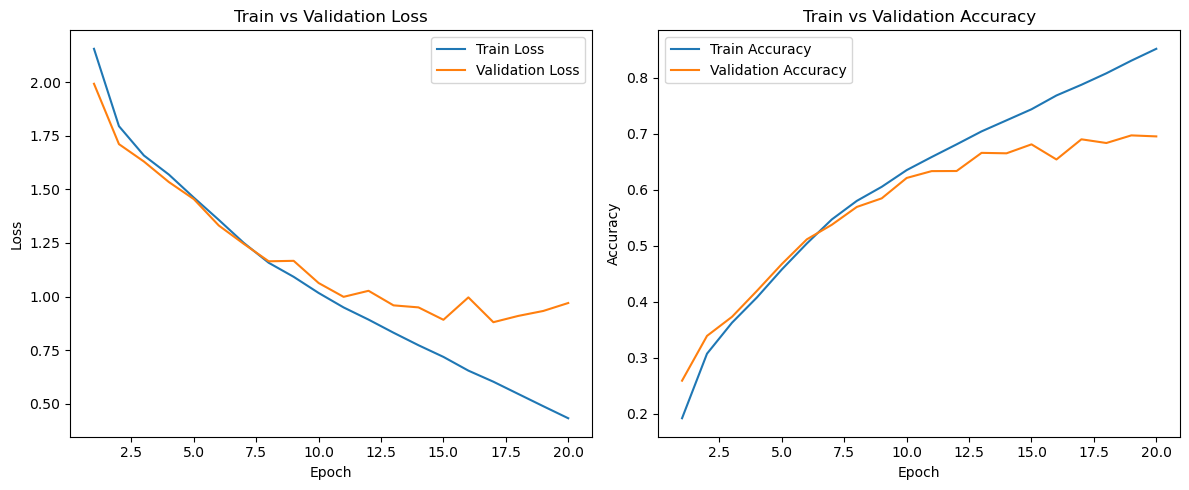

In [11]:
# initial setup
model_mobilenet = MobileNet(num_class)
model_mobilenet.to(device)
optimizer = optim.SGD(model_mobilenet.parameters(), lr=0.001, momentum=0.9)

mobile_weight_save_path = Path('./save_model/best_model_mobile_SGD_lr_0.001.pth')

model_training(model_mobilenet, train_dataloader, val_dataloader, num_epoch, mobile_weight_save_path, optimizer)

In [ ]:
best_model = MobileNet(num_class)
best_model.load_state_dict(torch.load(mobile_weight_save_path))
best_model.to(device)

test_step(best_model, test_dataloader)
torch.cuda.empty_cache()
time.sleep(30)

C:\Users\abrar\AppData\Local\Temp\ipykernel_29504\2979168291.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(mobile_weight_save_pat

Test Accuracy: 0.70

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1000
           1       0.74      0.93      0.83      1000
           2       0.70      0.50      0.58      1000
           3       0.52      0.46      0.48      1000
           4       0.64      0.63      0.64      1000
           5       0.56      0.65      0.60      1000
           6       0.74      0.77      0.75      1000
           7       0.67      0.77      0.72      1000
           8       0.78      0.86      0.82      1000
           9       0.85      0.78      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000



100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Epoch 1, Train Loss: 1.3874, Train Accuracy: 0.49, Validation Loss: 1.3318, Validation Accuracy: 0.54
Model saved with Validation Accuracy: 0.54


100%|██████████| 40/40 [00:05<00:00,  7.54it/s]


Epoch 2, Train Loss: 0.9154, Train Accuracy: 0.68, Validation Loss: 0.8408, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 3, Train Loss: 0.6890, Train Accuracy: 0.76, Validation Loss: 0.7176, Validation Accuracy: 0.75
Model saved with Validation Accuracy: 0.75


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 4, Train Loss: 0.5432, Train Accuracy: 0.81, Validation Loss: 0.7353, Validation Accuracy: 0.74


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 5, Train Loss: 0.4230, Train Accuracy: 0.85, Validation Loss: 0.7234, Validation Accuracy: 0.77
Model saved with Validation Accuracy: 0.77


100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


Epoch 6, Train Loss: 0.3348, Train Accuracy: 0.88, Validation Loss: 0.6335, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 7, Train Loss: 0.2654, Train Accuracy: 0.91, Validation Loss: 0.9513, Validation Accuracy: 0.73


100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Epoch 8, Train Loss: 0.2093, Train Accuracy: 0.93, Validation Loss: 0.7108, Validation Accuracy: 0.79


100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Epoch 9, Train Loss: 0.1696, Train Accuracy: 0.94, Validation Loss: 0.7479, Validation Accuracy: 0.79


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 10, Train Loss: 0.1445, Train Accuracy: 0.95, Validation Loss: 0.6908, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 11, Train Loss: 0.1062, Train Accuracy: 0.96, Validation Loss: 0.8120, Validation Accuracy: 0.79


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 12, Train Loss: 0.1036, Train Accuracy: 0.96, Validation Loss: 0.7349, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Epoch 13, Train Loss: 0.1045, Train Accuracy: 0.96, Validation Loss: 0.7453, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Epoch 14, Train Loss: 0.0873, Train Accuracy: 0.97, Validation Loss: 0.7479, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Epoch 15, Train Loss: 0.0746, Train Accuracy: 0.97, Validation Loss: 0.8756, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Epoch 16, Train Loss: 0.0642, Train Accuracy: 0.98, Validation Loss: 0.8113, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Epoch 17, Train Loss: 0.0695, Train Accuracy: 0.98, Validation Loss: 0.7998, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


Epoch 18, Train Loss: 0.0752, Train Accuracy: 0.97, Validation Loss: 0.9066, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 19, Train Loss: 0.0776, Train Accuracy: 0.97, Validation Loss: 0.8667, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Epoch 20, Train Loss: 0.0521, Train Accuracy: 0.98, Validation Loss: 0.8369, Validation Accuracy: 0.82


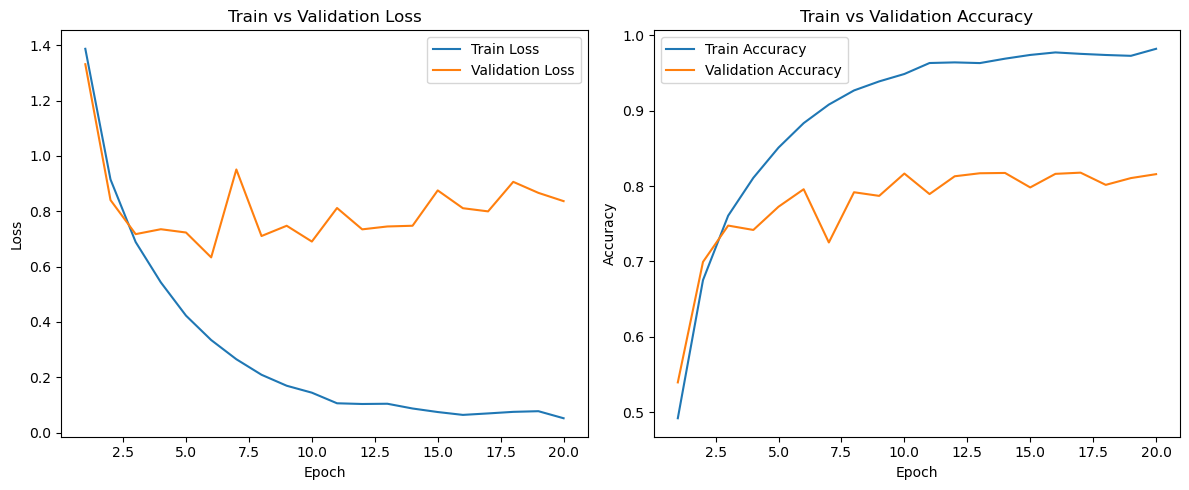

In [8]:
# Adam optimizer
model_mobilenet = MobileNet(num_class)
model_mobilenet.to(device)
optimizer = optim.Adam(model_mobilenet.parameters(), lr=0.001)

mobile_weight_save_path = Path('./save_model/best_model_mobile_adam_lr_0.001.pth')

model_training(model_mobilenet, train_dataloader, val_dataloader, num_epoch, mobile_weight_save_path, optimizer)

In [ ]:
best_model = MobileNet(num_class)
best_model.load_state_dict(torch.load(mobile_weight_save_path))
best_model.to(device)

test_step(best_model, test_dataloader)
torch.cuda.empty_cache()
time.sleep(30)

C:\Users\abrar\AppData\Local\Temp\ipykernel_33680\2979168291.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(mobile_weight_save_pat

Test Accuracy: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.88      0.95      0.91      1000
           2       0.80      0.73      0.76      1000
           3       0.66      0.68      0.67      1000
           4       0.84      0.75      0.80      1000
           5       0.76      0.70      0.73      1000
           6       0.90      0.84      0.87      1000
           7       0.77      0.91      0.83      1000
           8       0.89      0.91      0.90      1000
           9       0.87      0.90      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 1, Train Loss: 1.3583, Train Accuracy: 0.50, Validation Loss: 1.2499, Validation Accuracy: 0.56
Model saved with Validation Accuracy: 0.56


100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Epoch 2, Train Loss: 0.8822, Train Accuracy: 0.69, Validation Loss: 0.8672, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Epoch 3, Train Loss: 0.6685, Train Accuracy: 0.77, Validation Loss: 0.7498, Validation Accuracy: 0.75
Model saved with Validation Accuracy: 0.75


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 4, Train Loss: 0.5565, Train Accuracy: 0.81, Validation Loss: 0.6754, Validation Accuracy: 0.77
Model saved with Validation Accuracy: 0.77


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 5, Train Loss: 0.4894, Train Accuracy: 0.83, Validation Loss: 0.6009, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 6, Train Loss: 0.4399, Train Accuracy: 0.85, Validation Loss: 0.5903, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 7, Train Loss: 0.4049, Train Accuracy: 0.86, Validation Loss: 0.5867, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Epoch 8, Train Loss: 0.3777, Train Accuracy: 0.87, Validation Loss: 0.5738, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Epoch 9, Train Loss: 0.3528, Train Accuracy: 0.88, Validation Loss: 0.6186, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Epoch 10, Train Loss: 0.3247, Train Accuracy: 0.89, Validation Loss: 0.5959, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 11, Train Loss: 0.3108, Train Accuracy: 0.90, Validation Loss: 0.5742, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Epoch 12, Train Loss: 0.2923, Train Accuracy: 0.90, Validation Loss: 0.5364, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


Epoch 13, Train Loss: 0.2835, Train Accuracy: 0.90, Validation Loss: 0.4694, Validation Accuracy: 0.84
Model saved with Validation Accuracy: 0.84


100%|██████████| 40/40 [00:05<00:00,  7.83it/s]


Epoch 14, Train Loss: 0.2636, Train Accuracy: 0.91, Validation Loss: 0.5077, Validation Accuracy: 0.83


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Epoch 15, Train Loss: 0.2601, Train Accuracy: 0.91, Validation Loss: 0.5605, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Epoch 16, Train Loss: 0.2420, Train Accuracy: 0.92, Validation Loss: 0.5322, Validation Accuracy: 0.83


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 17, Train Loss: 0.2437, Train Accuracy: 0.92, Validation Loss: 0.5619, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Epoch 18, Train Loss: 0.2318, Train Accuracy: 0.92, Validation Loss: 0.5312, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Epoch 19, Train Loss: 0.2225, Train Accuracy: 0.92, Validation Loss: 0.5756, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 20, Train Loss: 0.2105, Train Accuracy: 0.93, Validation Loss: 0.5122, Validation Accuracy: 0.83


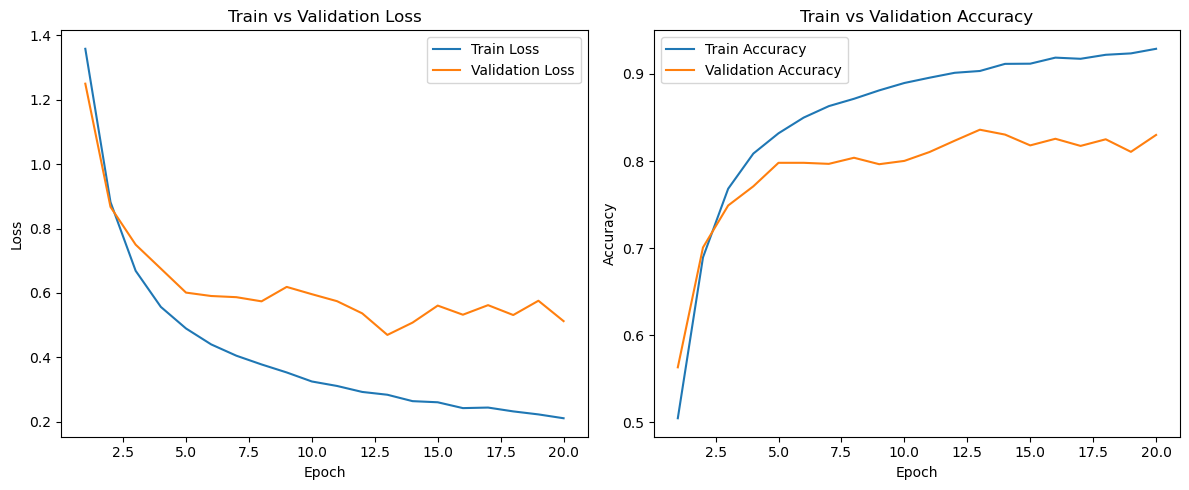

In [10]:
# Adam optimizer
model_mobilenet = MobileNet(num_class)
model_mobilenet.to(device)
optimizer = optim.Adam(model_mobilenet.parameters(), lr=0.001, weight_decay=1e-3)

mobile_weight_save_path = Path('./save_model/best_model_mobile_adam_lr_0.001_wd_{0.001}.pth')

model_training(model_mobilenet, train_dataloader, val_dataloader, num_epoch, mobile_weight_save_path, optimizer)

In [11]:
best_model = MobileNet(num_class)
best_model.load_state_dict(torch.load(mobile_weight_save_path))
best_model.to(device)

test_step(best_model, test_dataloader)
torch.cuda.empty_cache()
time.sleep(30)

C:\Users\abrar\AppData\Local\Temp\ipykernel_33680\2979168291.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(mobile_weight_save_pat

Test Accuracy: 0.84

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1000
           1       0.95      0.87      0.91      1000
           2       0.81      0.72      0.76      1000
           3       0.72      0.68      0.70      1000
           4       0.83      0.83      0.83      1000
           5       0.75      0.79      0.77      1000
           6       0.84      0.89      0.87      1000
           7       0.85      0.89      0.87      1000
           8       0.93      0.88      0.90      1000
           9       0.89      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

